In [1]:
import os, sys 
from google.colab import drive 

drive.mount('./content')

Mounted at ./content


In [2]:
cd content/MyDrive/LG_ObjectDetection/facedetect

/content/content/MyDrive/LG_ObjectDetection/facedetect


In [3]:
pwd

'/content/content/MyDrive/LG_ObjectDetection/facedetect'

In [ ]:
"""
파일 갯수 확인 :28224개 확인.
"""

import os

if __name__ == "__main__":
    root_dir = "./fddb/"
    files_sum = 0
    for (root, dirs, files) in os.walk(root_dir):
        #print("# root : " + root)
        # if len(dirs) > 0:
        #     for dir_name in dirs:
        #         print("dir: " + dir_name)

        if len(files) > 0: 
          files_sum += len(files)
          print(files_sum)
            # for file_name in files:
            #     print("file: " + file_name)

config

In [4]:
# YOLO options
YOLO_DARKNET_WEIGHTS        = "./model_data/yolov3.weights"
YOLO_COCO_CLASSES           = "./model_data/coco.names"
YOLO_STRIDES                = [8, 16, 32]
YOLO_IOU_LOSS_THRESH        = 0.5
YOLO_ANCHOR_PER_SCALE       = 3
YOLO_MAX_BBOX_PER_SCALE     = 100
YOLO_INPUT_SIZE             = 416
YOLO_ANCHORS                = [[[10,  13], [16,   30], [33,   23]],
                               [[30,  61], [62,   45], [59,  119]],
                               [[116, 90], [156, 198], [373, 326]]]
# Train options
TRAIN_CLASSES               = "./model_data/face.names"
TRAIN_ANNOT_PATH            = "./train_fddb.txt"
TRAIN_BATCH_SIZE            = 4
TRAIN_INPUT_SIZE            = 416
TRAIN_DATA_AUG              = True
TRAIN_TRANSFER              = False #첫 학습시킬때는 True
TRAIN_FROM_CHECKPOINT       = "./checkpoints/yolov3_custom"

TRAIN_LR_INIT               = 1e-4
TRAIN_LR_END                = 1e-6
TRAIN_WARMUP_EPOCHS         = 2
TRAIN_EPOCHS                = 1

# TEST options
TEST_ANNOT_PATH             = "./test_fddb.txt"
TEST_BATCH_SIZE             = 4
TEST_INPUT_SIZE             = 416
TEST_DATA_AUG               = False

In [5]:
import cv2
import time
import random
import colorsys
import numpy as np
import tensorflow as tf

from tensorflow.keras.layers import Conv2D, Input, LeakyReLU, ZeroPadding2D, BatchNormalization
from tensorflow.keras.regularizers import l2

from src.utils import load_yolo_weights, read_class_names, image_preprocess, draw_bbox, bboxes_iou, nms, postprocess_boxes, detect_image
from src.Yolov3Body import Create_Yolov3, bbox_iou, compute_loss

model

In [6]:
STRIDES         = np.array(YOLO_STRIDES)
ANCHORS         = (np.array(YOLO_ANCHORS).T/STRIDES).T
IOU_LOSS_THRESH = YOLO_IOU_LOSS_THRESH

dataset 

In [7]:
import os
import cv2
import random
import numpy as np
import tensorflow as tf


class Dataset(object):
    # Dataset preprocess implementation
    
    def __init__(self, dataset_type):        
        self.annot_path  = TRAIN_ANNOT_PATH if dataset_type == 'train' else TEST_ANNOT_PATH
        self.input_sizes = TRAIN_INPUT_SIZE if dataset_type == 'train' else TEST_INPUT_SIZE
        self.batch_size  = TRAIN_BATCH_SIZE if dataset_type == 'train' else TEST_BATCH_SIZE
        self.data_aug    = TRAIN_DATA_AUG   if dataset_type == 'train' else TEST_DATA_AUG
        self.test_annot_path = TEST_ANNOT_PATH

        self.train_input_sizes = TRAIN_INPUT_SIZE
        self.strides = np.array(YOLO_STRIDES)
        self.classes = read_class_names(TRAIN_CLASSES)
        self.num_classes = len(self.classes)
        self.anchors = (np.array(YOLO_ANCHORS).T/self.strides).T
        self.anchor_per_scale = YOLO_ANCHOR_PER_SCALE
        self.max_bbox_per_scale = YOLO_MAX_BBOX_PER_SCALE

        self.annotations = self.load_annotations(dataset_type)
        self.num_samples = len(self.annotations)
        self.num_batchs = int(np.ceil(self.num_samples / self.batch_size))
        self.batch_count = 0


    def load_annotations(self, dataset_type):
        final_annotations = []
        with open(self.annot_path, 'r') as f:
            txt = f.readlines()
            annotations = [line.strip() for line in txt if len(line.strip().split()[1:]) != 0]
        np.random.seed(0)
        np.random.shuffle(annotations)
        np.random.seed(None)
        
        if (dataset_type == 'train') & (not os.path.exists(self.test_annot_path)):
            idx = round(len(annotations)*0.7)

            test_annotations = annotations[idx:]
            annotations = annotations[:idx]
            
            f_annotation=open(self.test_annot_path, mode="w", encoding='utf-8')
            for line in test_annotations:
                f_annotation.write(line)
                f_annotation.write("\n")
            f_annotation.close()
        
        
        for annotation in annotations:
            # fully parse annotations
            line = annotation.split()
            image_path, index = "", 1
            for i, one_line in enumerate(line):
                if not one_line.replace(",","").isnumeric():
                    if image_path != "": image_path += " "
                    image_path += one_line
                else:
                    index = i
                    break
            if not os.path.exists(image_path):
                raise KeyError("%s does not exist ... " %image_path)

            final_annotations.append([image_path, line[index:]])

        return final_annotations

    def __iter__(self):
        return self

    def __next__(self):
        with tf.device('/cpu:0'):
            self.train_input_size = random.choice([self.train_input_sizes])
            self.train_output_sizes = self.train_input_size // self.strides

            batch_image = np.zeros((self.batch_size, self.train_input_size, self.train_input_size, 3), dtype=np.float32)

            batch_label_sbbox = np.zeros((self.batch_size, self.train_output_sizes[0], self.train_output_sizes[0],
                                          self.anchor_per_scale, 5 + self.num_classes), dtype=np.float32)
            batch_label_mbbox = np.zeros((self.batch_size, self.train_output_sizes[1], self.train_output_sizes[1],
                                          self.anchor_per_scale, 5 + self.num_classes), dtype=np.float32)
            batch_label_lbbox = np.zeros((self.batch_size, self.train_output_sizes[2], self.train_output_sizes[2],
                                          self.anchor_per_scale, 5 + self.num_classes), dtype=np.float32)

            batch_sbboxes = np.zeros((self.batch_size, self.max_bbox_per_scale, 4), dtype=np.float32)
            batch_mbboxes = np.zeros((self.batch_size, self.max_bbox_per_scale, 4), dtype=np.float32)
            batch_lbboxes = np.zeros((self.batch_size, self.max_bbox_per_scale, 4), dtype=np.float32)

            num = 0
            if self.batch_count < self.num_batchs:
                while num < self.batch_size:
                    index = self.batch_count * self.batch_size + num
                    if index >= self.num_samples: index -= self.num_samples
                    annotation = self.annotations[index]
                    image, bboxes = self.parse_annotation(annotation)
                    label_sbbox, label_mbbox, label_lbbox, sbboxes, mbboxes, lbboxes = self.preprocess_true_boxes(bboxes)

                    batch_image[num, :, :, :] = image
                    batch_label_sbbox[num, :, :, :, :] = label_sbbox
                    batch_label_mbbox[num, :, :, :, :] = label_mbbox
                    batch_label_lbbox[num, :, :, :, :] = label_lbbox
                    batch_sbboxes[num, :, :] = sbboxes
                    batch_mbboxes[num, :, :] = mbboxes
                    batch_lbboxes[num, :, :] = lbboxes
                    num += 1
                self.batch_count += 1
                batch_smaller_target = batch_label_sbbox, batch_sbboxes
                batch_medium_target  = batch_label_mbbox, batch_mbboxes
                batch_larger_target  = batch_label_lbbox, batch_lbboxes

                return batch_image, (batch_smaller_target, batch_medium_target, batch_larger_target)
            else:
                self.batch_count = 0
                np.random.shuffle(self.annotations)
                raise StopIteration

    def random_horizontal_flip(self, image, bboxes):
        if random.random() < 0.5:
            _, w, _ = image.shape
            image = image[:, ::-1, :]
            bboxes[:, [0,2]] = w - bboxes[:, [2,0]]

        return image, bboxes

    def random_crop(self, image, bboxes):
        if random.random() < 0.5:
            h, w, _ = image.shape
            max_bbox = np.concatenate([np.min(bboxes[:, 0:2], axis=0), np.max(bboxes[:, 2:4], axis=0)], axis=-1)

            max_l_trans = max_bbox[0]
            max_u_trans = max_bbox[1]
            max_r_trans = w - max_bbox[2]
            max_d_trans = h - max_bbox[3]

            crop_xmin = max(0, int(max_bbox[0] - random.uniform(0, max_l_trans)))
            crop_ymin = max(0, int(max_bbox[1] - random.uniform(0, max_u_trans)))
            crop_xmax = max(w, int(max_bbox[2] + random.uniform(0, max_r_trans)))
            crop_ymax = max(h, int(max_bbox[3] + random.uniform(0, max_d_trans)))

            image = image[crop_ymin : crop_ymax, crop_xmin : crop_xmax]

            bboxes[:, [0, 2]] = bboxes[:, [0, 2]] - crop_xmin
            bboxes[:, [1, 3]] = bboxes[:, [1, 3]] - crop_ymin

        return image, bboxes

    def random_translate(self, image, bboxes):
        if random.random() < 0.5:
            h, w, _ = image.shape
            max_bbox = np.concatenate([np.min(bboxes[:, 0:2], axis=0), np.max(bboxes[:, 2:4], axis=0)], axis=-1)

            max_l_trans = max_bbox[0]
            max_u_trans = max_bbox[1]
            max_r_trans = w - max_bbox[2]
            max_d_trans = h - max_bbox[3]

            tx = random.uniform(-(max_l_trans - 1), (max_r_trans - 1))
            ty = random.uniform(-(max_u_trans - 1), (max_d_trans - 1))

            M = np.array([[1, 0, tx], [0, 1, ty]])
            image = cv2.warpAffine(image, M, (w, h))

            bboxes[:, [0, 2]] = bboxes[:, [0, 2]] + tx
            bboxes[:, [1, 3]] = bboxes[:, [1, 3]] + ty

        return image, bboxes

    def parse_annotation(self, annotation):

        image_path = annotation[0]
        image = cv2.imread(image_path)
            
        bboxes = np.array([list(map(int, box.split(','))) for box in annotation[1]])

        if self.data_aug:
            image, bboxes = self.random_horizontal_flip(np.copy(image), np.copy(bboxes))
            image, bboxes = self.random_crop(np.copy(image), np.copy(bboxes))
            image, bboxes = self.random_translate(np.copy(image), np.copy(bboxes))

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image, bboxes = image_preprocess(np.copy(image), [self.train_input_size, self.train_input_size], np.copy(bboxes))
        return image, bboxes

    def preprocess_true_boxes(self, bboxes):
        label = [np.zeros((self.train_output_sizes[i], self.train_output_sizes[i], self.anchor_per_scale,
                           5 + self.num_classes)) for i in range(3)]
        bboxes_xywh = [np.zeros((self.max_bbox_per_scale, 4)) for _ in range(3)]
        bbox_count = np.zeros((3,))

        for bbox in bboxes:
            bbox_coor = bbox[:4]
            bbox_class_ind = bbox[4]

            onehot = np.zeros(self.num_classes, dtype=np.float)
            onehot[bbox_class_ind] = 1.0
            uniform_distribution = np.full(self.num_classes, 1.0 / self.num_classes)
            deta = 0.01
            smooth_onehot = onehot * (1 - deta) + deta * uniform_distribution

            bbox_xywh = np.concatenate([(bbox_coor[2:] + bbox_coor[:2]) * 0.5, bbox_coor[2:] - bbox_coor[:2]], axis=-1)
            bbox_xywh_scaled = 1.0 * bbox_xywh[np.newaxis, :] / self.strides[:, np.newaxis]

            iou = []
            exist_positive = False
            for i in range(3):
                anchors_xywh = np.zeros((self.anchor_per_scale, 4))
                anchors_xywh[:, 0:2] = np.floor(bbox_xywh_scaled[i, 0:2]).astype(np.int32) + 0.5
                anchors_xywh[:, 2:4] = self.anchors[i]

                iou_scale = bbox_iou(bbox_xywh_scaled[i][np.newaxis, :], anchors_xywh)
                iou.append(iou_scale)
                iou_mask = iou_scale > 0.3

                if np.any(iou_mask):
                    xind, yind = np.floor(bbox_xywh_scaled[i, 0:2]).astype(np.int32)

                    label[i][yind, xind, iou_mask, :] = 0
                    label[i][yind, xind, iou_mask, 0:4] = bbox_xywh
                    label[i][yind, xind, iou_mask, 4:5] = 1.0
                    label[i][yind, xind, iou_mask, 5:] = smooth_onehot

                    bbox_ind = int(bbox_count[i] % self.max_bbox_per_scale)
                    bboxes_xywh[i][bbox_ind, :4] = bbox_xywh
                    bbox_count[i] += 1

                    exist_positive = True

            if not exist_positive:
                best_anchor_ind = np.argmax(np.array(iou).reshape(-1), axis=-1)
                best_detect = int(best_anchor_ind / self.anchor_per_scale)
                best_anchor = int(best_anchor_ind % self.anchor_per_scale)
                xind, yind = np.floor(bbox_xywh_scaled[best_detect, 0:2]).astype(np.int32)

                label[best_detect][yind, xind, best_anchor, :] = 0
                label[best_detect][yind, xind, best_anchor, 0:4] = bbox_xywh
                label[best_detect][yind, xind, best_anchor, 4:5] = 1.0
                label[best_detect][yind, xind, best_anchor, 5:] = smooth_onehot
                
                bbox_ind = int(bbox_count[best_detect] % self.max_bbox_per_scale)
                bboxes_xywh[best_detect][bbox_ind, :4] = bbox_xywh
                bbox_count[best_detect] += 1

        label_sbbox, label_mbbox, label_lbbox = label
        sbboxes, mbboxes, lbboxes = bboxes_xywh
        return label_sbbox, label_mbbox, label_lbbox, sbboxes, mbboxes, lbboxes

    def __len__(self):
        return self.num_batchs

In [8]:
#train mode로 시작하여 train:test 7:3으로 분리(shuffle)
trainset = Dataset('train')
testset = Dataset('test')

training

In [9]:
import os
import shutil
import numpy as np
import tensorflow as tf

global TRAIN_FROM_CHECKPOINT
input_size = YOLO_INPUT_SIZE
Darknet_weights = YOLO_DARKNET_WEIGHTS


save_best_only = True # saves only best model according validation loss
save_checkpoints = False # saves all best validated checkpoints in training process (may require a lot disk space)


steps_per_epoch = len(trainset)
global_steps = tf.Variable(1, trainable=False, dtype=tf.int64)
warmup_steps = TRAIN_WARMUP_EPOCHS * steps_per_epoch
total_steps = TRAIN_EPOCHS * steps_per_epoch

if TRAIN_TRANSFER:
    Darknet = Create_Yolov3(CLASSES=YOLO_COCO_CLASSES, STRIDES=STRIDES, ANCHORS=ANCHORS, input_size=input_size)
    load_yolo_weights(Darknet, Darknet_weights) # use darknet weights

yolo = Create_Yolov3(CLASSES=TRAIN_CLASSES, STRIDES=STRIDES, ANCHORS=ANCHORS, input_size=input_size, training=True)

#TRAIN_FROM_CHECKPOINT = False
if TRAIN_FROM_CHECKPOINT:
    yolo.load_weights(TRAIN_FROM_CHECKPOINT)

## transfer && Not use checkpoint
if TRAIN_TRANSFER and not TRAIN_FROM_CHECKPOINT:
    for i, l in enumerate(Darknet.layers):
        layer_weights = l.get_weights()
        if layer_weights != []:
            try:
                yolo.layers[i].set_weights(layer_weights)
            except:
                print("skipping", yolo.layers[i].name)

optimizer = tf.keras.optimizers.Adam()

def train_step(image_data, target):
    with tf.GradientTape() as tape:
        pred_result = yolo(image_data, training=True)
        giou_loss=conf_loss=prob_loss=0
        # optimizing process
        for i in range(3):
            conv, pred = pred_result[i*2], pred_result[i*2+1]
            loss_items = compute_loss(pred, conv, *target[i], TRAIN_CLASSES, STRIDES, IOU_LOSS_THRESH, i)
            giou_loss += loss_items[0]
            conf_loss += loss_items[1]
            prob_loss += loss_items[2]
        total_loss = giou_loss + conf_loss + prob_loss
        gradients = tape.gradient(total_loss, yolo.trainable_variables)
        optimizer.apply_gradients(zip(gradients, yolo.trainable_variables))


        # update learning rate
        global_steps.assign_add(1)
        if global_steps < warmup_steps:# and not TRAIN_TRANSFER:
            lr = global_steps / warmup_steps * TRAIN_LR_INIT
        else:
            lr = TRAIN_LR_END + 0.5 * (TRAIN_LR_INIT - TRAIN_LR_END)*(
                (1 + tf.cos((global_steps - warmup_steps) / (total_steps - warmup_steps) * np.pi)))
        optimizer.lr.assign(lr.numpy())

    return global_steps.numpy(), optimizer.lr.numpy(), giou_loss.numpy(), conf_loss.numpy(), prob_loss.numpy(), total_loss.numpy()



def validate_step(image_data, target):
    with tf.GradientTape() as tape:
        pred_result = yolo(image_data, training=False)
        giou_loss=conf_loss=prob_loss=0

        # optimizing process
        for i in range(3):
            conv, pred = pred_result[i*2], pred_result[i*2+1]
            loss_items = compute_loss(pred, conv, *target[i], TRAIN_CLASSES, STRIDES, IOU_LOSS_THRESH, i)
            giou_loss += loss_items[0]
            conf_loss += loss_items[1]
            prob_loss += loss_items[2]

        total_loss = giou_loss + conf_loss + prob_loss
        
    return giou_loss.numpy(), conf_loss.numpy(), prob_loss.numpy(), total_loss.numpy()

In [10]:
best_val_loss = 1000 # should be large at start


for epoch in range(TRAIN_EPOCHS):
    for image_data, target in trainset:
        results = train_step(image_data, target)
        cur_step = results[0]%steps_per_epoch
        print("epoch:{:2.0f} step:{:5.0f}/{}, lr:{:.6f}, giou_loss:{:7.2f}, conf_loss:{:7.2f}, prob_loss:{:7.2f}, total_loss:{:7.2f}"
                  .format(epoch, cur_step, steps_per_epoch, results[1], results[2], results[3], results[4], results[5]))
        
    count, giou_val, conf_val, prob_val, total_val = 0., 0, 0, 0, 0
    for image_data, target in testset:
        results = validate_step(image_data, target)
        count += 1
        giou_val += results[0]
        conf_val += results[1]
        prob_val += results[2]
        total_val += results[3]

        
    print("\n\ngiou_val_loss:{:7.2f}, conf_val_loss:{:7.2f}, prob_val_loss:{:7.2f}, total_val_loss:{:7.2f}\n\n".
          format(giou_val/count, conf_val/count, prob_val/count, total_val/count))

    if save_best_only and best_val_loss > total_val/count: 
        yolo.save_weights("./checkpoints/yolov3_custom")
        best_val_loss = total_val/count

epoch: 0 step:    2/697, lr:0.000000, giou_loss:   2.73, conf_loss:   3.50, prob_loss:   0.06, total_loss:   6.28
epoch: 0 step:    3/697, lr:0.000000, giou_loss:   6.34, conf_loss:  54.63, prob_loss:   0.62, total_loss:  61.59
epoch: 0 step:    4/697, lr:0.000000, giou_loss:   7.46, conf_loss:  47.99, prob_loss:   0.43, total_loss:  55.89
epoch: 0 step:    5/697, lr:0.000000, giou_loss:  10.54, conf_loss:  51.82, prob_loss:   0.26, total_loss:  62.62
epoch: 0 step:    6/697, lr:0.000000, giou_loss:  12.61, conf_loss:  58.37, prob_loss:   0.40, total_loss:  71.38
epoch: 0 step:    7/697, lr:0.000001, giou_loss:   5.11, conf_loss:  55.21, prob_loss:   0.78, total_loss:  61.10
epoch: 0 step:    8/697, lr:0.000001, giou_loss:   6.03, conf_loss:  53.48, prob_loss:   0.54, total_loss:  60.05
epoch: 0 step:    9/697, lr:0.000001, giou_loss:   6.21, conf_loss:  54.80, prob_loss:   0.94, total_loss:  61.95
epoch: 0 step:   10/697, lr:0.000001, giou_loss:   7.11, conf_loss:  53.49, prob_loss:  

test

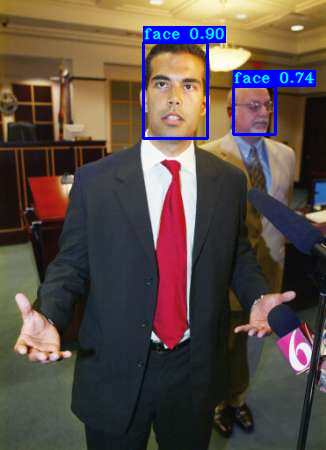

In [11]:

import os
import cv2
import numpy as np
import random
import time
import tensorflow as tf
from google.colab.patches import cv2_imshow


YOLO_INPUT_SIZE = 416
input_size=YOLO_INPUT_SIZE



image_path ="./fddb/originalPics/2002/07/19/big/img_372.jpg" #image_info[0]

yolo = Create_Yolov3(input_size=input_size, CLASSES=TRAIN_CLASSES, STRIDES=STRIDES, ANCHORS=ANCHORS)
yolo.load_weights("./checkpoints/yolov3_custom")



img = detect_image(yolo, image_path, "", input_size=input_size, show=True, CLASSES=TRAIN_CLASSES, rectangle_colors=(255,0,0))
cv2_imshow(img)

In [ ]:
image_path

'./fruits/test/mix_25.jpg'

In [ ]:
yolo.save('my_model.h5')


In [ ]:
loaded_model = tf.keras.models.load_model('my_model.h5')

loaded_model.load_weights("./checkpoints/yolov3_custom")

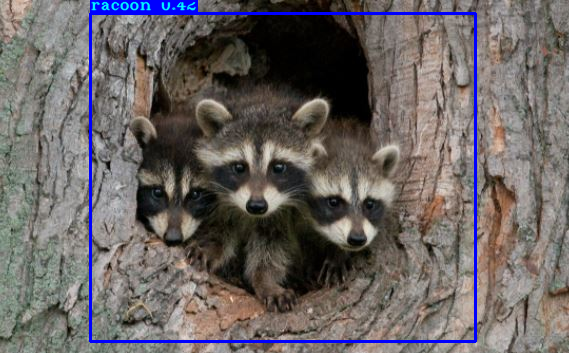

In [ ]:
#loaded_model.summary()
img = detect_image(loaded_model, image_path, "", input_size=input_size, show=True, CLASSES=TRAIN_CLASSES, rectangle_colors=(255,0,0))
cv2_imshow(img)